# Spatial data in pytidycensus

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mmann1123/pytidycensus/blob/main/examples/02_spatial_data.ipynb)

This notebook demonstrates how to work with spatial data in **pytidycensus**, including creating maps and performing spatial analysis with GeoPandas.

## Setup

First, let's install and import the necessary packages:

In [1]:
# Uncomment to install if running in Colab
# !pip install pytidycensus geopandas matplotlib contextily

import pytidycensus as tc
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

# Set up matplotlib
plt.style.use('default')
%matplotlib inline

## Census API Key Setup

Set your Census API key (get one at https://api.census.gov/data/key_signup.html):

In [2]:
# Replace with your actual API key
tc.set_census_api_key("983980b9fc504149e82117c949d7ed44653dc507")

Census API key has been set for this session.


## Getting Spatial Data

When you set `geometry=True` in pytidycensus functions, the package automatically downloads the corresponding TIGER/Line shapefiles and merges them with your data.

### Example: Median Household Income in Orange County, CA

Let's get median household income for Census tracts in Orange County, California:

In [3]:
# Get ACS data with geometry for Orange County, CA
orange = tc.get_acs(
    state="CA",
    county="Orange",
    geography="tract",
    variables="B19013_001",  # Median household income
    geometry=True,
    year=2022
)

print(f"Data type: {type(orange)}")
print(f"Shape: {orange.shape}")
print(f"CRS: {orange.crs}")
orange.head()

Getting data from the 2018-2022 5-year ACS
Loading tract boundaries...
Data type: <class 'geopandas.geodataframe.GeoDataFrame'>
Shape: (614, 11)
CRS: EPSG:4269


,GEOID,NAME,geometry,STATEFP,COUNTYFP,TRACTCE,B19013_001E,state,county,tract,B19013_001_moe
0,06059990100,9901,"POLYGON ((-118.14153 33.70362, -118.12858 33.7...",06,059,990100,<NA>,06,059,990100,<NA>
1,06059062649,626.49,"POLYGON ((-117.7616 33.58442, -117.76157 33.58...",06,059,062649,75028,06,059,062649,18255.0
2,06059032058,320.58,"POLYGON ((-117.65902 33.55605, -117.65666 33.5...",06,059,032058,232719,06,059,032058,29201.0
3,06059032061,320.61,"POLYGON ((-117.66979 33.52778, -117.66967 33.5...",06,059,032061,154940,06,059,032061,26818.0
4,06059021813,218.13,"POLYGON ((-117.83796 33.85113, -117.83795 33.8...",06,059,021813,<NA>,06,059,021813,<NA>


The returned object is a **GeoDataFrame** with a `geometry` column containing the spatial boundaries. The default coordinate system is NAD83 (EPSG:4269).

## Basic Choropleth Mapping

Let's create a basic choropleth map:

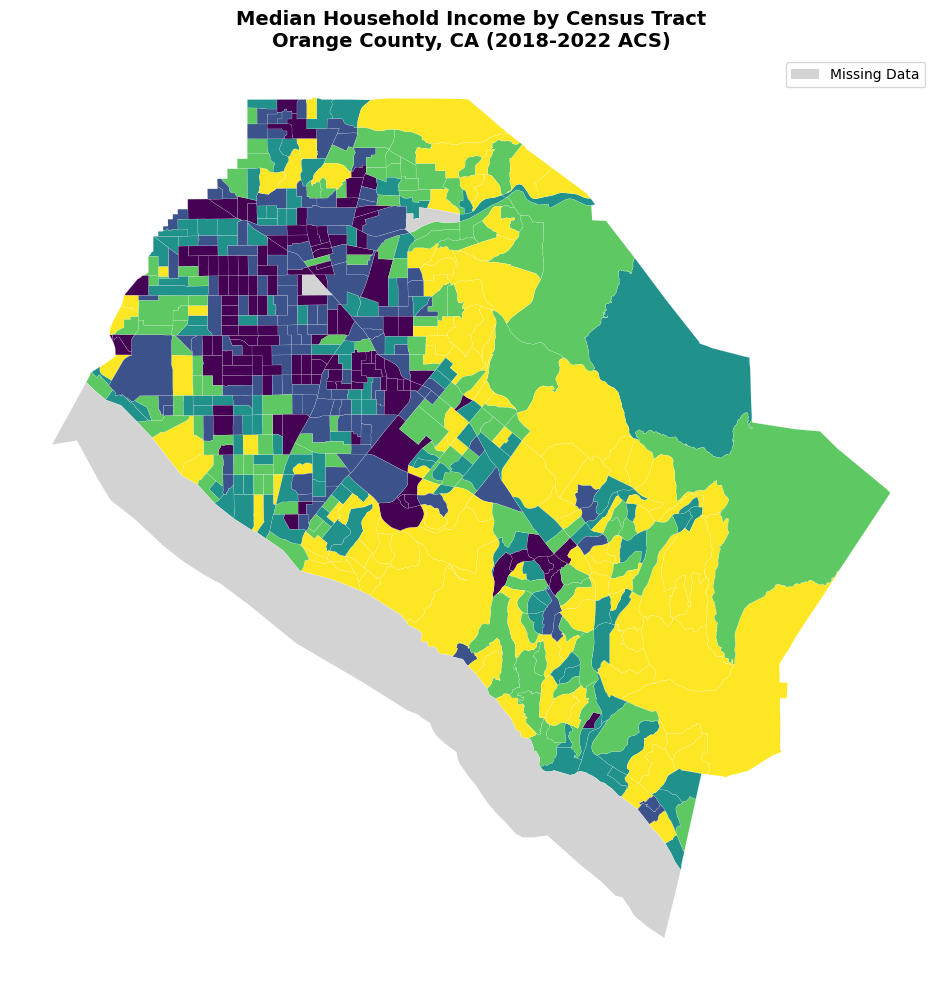

In [4]:
# Create a basic choropleth map with missing data highlighted
fig, ax = plt.subplots(figsize=(12, 10))

# Create a mask for missing values
missing_mask = orange["B19013_001E"].isna()

# Plot non-missing data with color scheme
orange[~missing_mask].plot(
    column="B19013_001E",
    cmap="viridis",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
    scheme="quantiles",  # or "equal_interval"
    k=5,
)

# Plot missing data with distinct color
orange[missing_mask].plot(
    color="lightgray",  # or any color for missing data
    linewidth=0.1,
    edgecolor="white",
    ax=ax,
)

ax.set_title(
    "Median Household Income by Census Tract\nOrange County, CA (2018-2022 ACS)",
    fontsize=14,
    fontweight="bold",
)
ax.set_axis_off()

# Add missing data to legend
from matplotlib.patches import Patch

handles, labels = ax.get_legend_handles_labels()
handles.append(Patch(facecolor="lightgray", label="Missing Data"))
ax.legend(handles=handles, loc="upper right")

plt.tight_layout()
plt.show()

## Coordinate Reference Systems

For better visualization and analysis, it's often useful to project the data to an appropriate coordinate system:

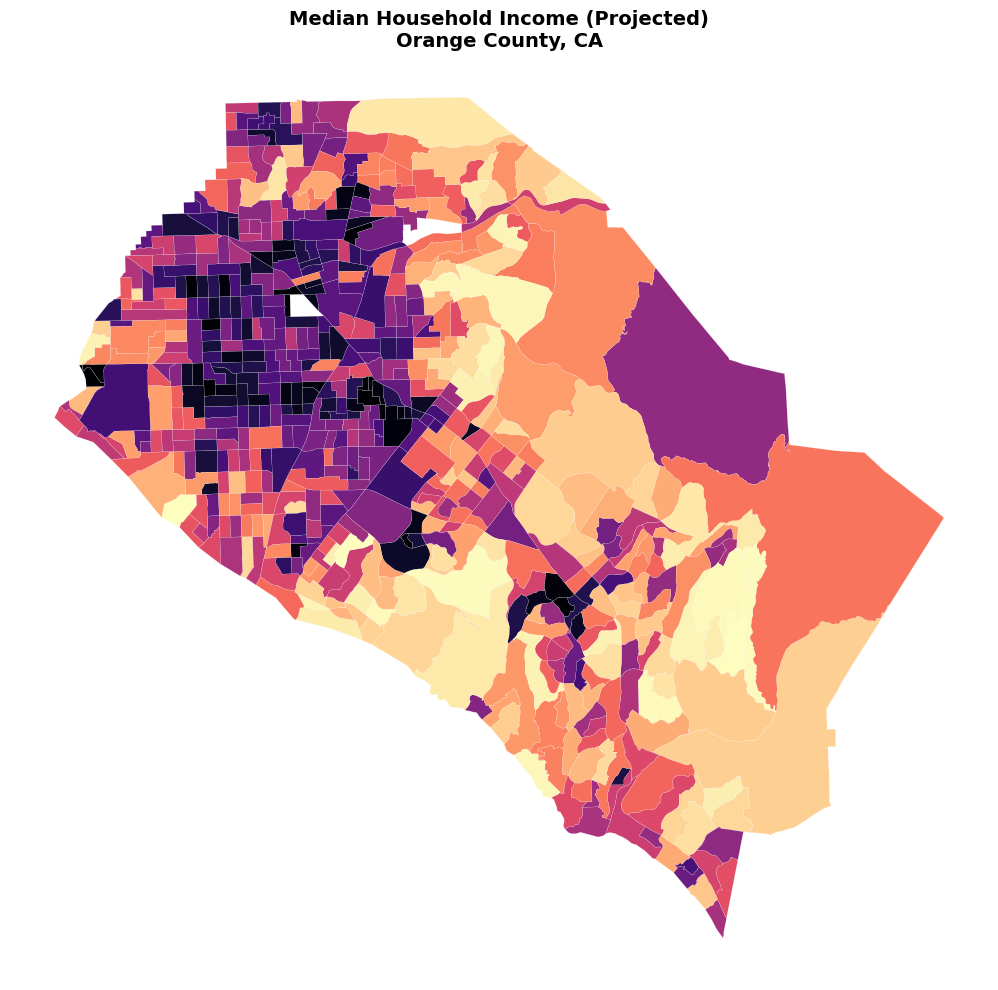

In [5]:
# Project to California Albers (EPSG:3310) for better area representation
orange_projected = orange.to_crs('EPSG:3310')

fig, ax = plt.subplots(figsize=(12, 10))

orange_projected.plot(
    column="B19013_001E",
    cmap="magma",
    linewidth=0.1,
    edgecolor="white",
    legend=False,
    ax=ax,
)

ax.set_title('Median Household Income (Projected)\nOrange County, CA', 
             fontsize=14, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.show()

## Faceted Mapping

One powerful feature is creating small multiples to compare different variables. Let's look at racial demographics in Harris County, Texas.

### Race/Ethnicity Data with Summary Variable

In [6]:
# Define race/ethnicity variables for 2020 Census
race_vars = {
    "White": "P2_005N",
    "Black": "P2_006N", 
    "Asian": "P2_008N",
    "Hispanic": "P2_002N"
}

# Get data for Harris County, TX with total population as summary variable
harris = tc.get_decennial(
    geography="tract",
    variables=race_vars,
    state="TX",
    county="Harris",
    geometry=True,
    summary_var="P2_001N",  # Total population
    year=2020,
    sumfile="pl"
)

print(f"Shape: {harris.shape}")
harris.head()

Getting data from the 2020 decennial Census
Using the PL 94-171 Redistricting Data Summary File
Loading tract boundaries...
Shape: (4460, 13)


,GEOID,NAME,geometry,STATEFP,COUNTYFP,TRACTCE,summary_value_x,state,county,tract,variable,value,summary_value_y
0,48201233105,2331.05,"POLYGON ((-95.16994 29.79037, -95.16731 29.790...",48,201,233105,3734,48,201,233105,White,373,NaN
1,48201233105,2331.05,"POLYGON ((-95.16994 29.79037, -95.16731 29.790...",48,201,233105,3734,48,201,233105,Black,62,NaN
2,48201233105,2331.05,"POLYGON ((-95.16994 29.79037, -95.16731 29.790...",48,201,233105,3734,48,201,233105,Asian,2,NaN
3,48201233105,2331.05,"POLYGON ((-95.16994 29.79037, -95.16731 29.790...",48,201,233105,3734,48,201,233105,Hispanic,3268,NaN
4,48201252201,2522.01,"POLYGON ((-95.1753 29.83223, -95.17486 29.8324...",48,201,252201,4838,48,201,252201,White,376,NaN


Notice that we have multiple rows per tract (one for each race/ethnicity variable) and a `summary_value` column with the total population.

### Calculate Percentages and Create Faceted Map

In [7]:
# Calculate percentage of total population
harris['percent'] = 100 * (harris['value'] / harris['summary_value'])
harris.head()

KeyError: 'summary_value'

In [ ]:

# Create faceted map
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Get unique variables for iteration
variables = harris['variable'].unique()

for i, var in enumerate(variables):
    # Filter data for this variable
    subset = harris[harris['variable'] == var]
    
    # Create map
    subset.plot(
        column='percent',
        cmap='viridis',
        linewidth=0,
        legend=True,
        ax=axes[i],
        vmin=0,
        vmax=80  # Set consistent scale
    )
    
    axes[i].set_title(f'{var}', fontsize=12, fontweight='bold')
    axes[i].set_axis_off()

plt.suptitle('Racial and Ethnic Geography of Harris County, TX\n2020 Census (% of Total Population)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Interactive Analysis

Let's explore the data interactively by looking at summary statistics:

In [ ]:
# Summary statistics by race/ethnicity
summary_stats = harris.groupby('variable')['percent'].describe()
print("Percentage Distribution by Race/Ethnicity:")
print(summary_stats.round(2))

In [ ]:
# Create box plots to show distribution
fig, ax = plt.subplots(figsize=(10, 6))

harris.boxplot(column='percent', by='variable', ax=ax)
ax.set_title('Distribution of Race/Ethnicity Percentages by Census Tract\nHarris County, TX')
ax.set_xlabel('Race/Ethnicity Group')
ax.set_ylabel('Percentage of Total Population')
plt.xticks(rotation=45)
plt.suptitle('')  # Remove automatic title
plt.tight_layout()
plt.show()

## Working with Different Geographic Levels

### State-Level Data

Let's create a map of median household income for all US states:

In [ ]:
# Get median household income for all states
states_income = tc.get_acs(
    geography="state",
    variables="B19013_001",
    year=2022,
    geometry=True
)

# Remove territories for cleaner continental US map
states_continental = states_income[
    ~states_income['NAME'].isin([
        'Puerto Rico', 'United States Virgin Islands', 
        'Guam', 'American Samoa', 'Commonwealth of the Northern Mariana Islands'
    ])
]

print(f"Number of states/DC: {len(states_continental)}")

In [ ]:
# Project to Albers Equal Area for US mapping
states_albers = states_continental.to_crs('EPSG:5070')

fig, ax = plt.subplots(figsize=(15, 10))

states_albers.plot(
    column='value',
    cmap='RdYlBu_r',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    ax=ax
)

ax.set_title('Median Household Income by State\n2018-2022 American Community Survey', 
             fontsize=16, fontweight='bold')
ax.set_axis_off()

# Add colorbar label
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Median Household Income ($)', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

### County-Level Analysis

Let's look at population density across counties in a specific state:

In [ ]:
# Get population and calculate density for California counties
ca_counties = tc.get_acs(
    geography="county",
    variables="B01003_001",  # Total population
    state="CA",
    year=2022,
    geometry=True
)

# Calculate area in square kilometers and population density
ca_counties_proj = ca_counties.to_crs('EPSG:3310')  # California Albers
ca_counties_proj['area_km2'] = ca_counties_proj.geometry.area / 1e6
ca_counties_proj['density'] = ca_counties_proj['value'] / ca_counties_proj['area_km2']

print("Top 10 most dense counties:")
print(ca_counties_proj.nlargest(10, 'density')[['NAME', 'density']].round(1))

In [ ]:
# Map population density with log scale
fig, ax = plt.subplots(figsize=(12, 15))

# Use log scale for better visualization of density
ca_counties_proj['log_density'] = np.log10(ca_counties_proj['density'] + 1)

ca_counties_proj.plot(
    column='log_density',
    cmap='OrRd',
    linewidth=0.2,
    edgecolor='white',
    legend=True,
    ax=ax
)

ax.set_title('Population Density by County\nCalifornia (Log Scale)', 
             fontsize=14, fontweight='bold')
ax.set_axis_off()

plt.tight_layout()
plt.show()

## Advanced Visualization Techniques

### Using Different Color Schemes

In [ ]:
# Compare different color schemes
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

cmaps = ['viridis', 'plasma', 'RdYlBu_r', 'coolwarm']
titles = ['Viridis', 'Plasma', 'RdYlBu_r', 'Coolwarm']

for i, (cmap, title) in enumerate(zip(cmaps, titles)):
    orange_projected.plot(
        column='value',
        cmap=cmap,
        linewidth=0.1,
        edgecolor='white',
        legend=True,
        ax=axes[i]
    )
    axes[i].set_title(f'{title} Color Scheme', fontweight='bold')
    axes[i].set_axis_off()

plt.suptitle('Median Household Income - Different Color Schemes\nOrange County, CA', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

### Classification Schemes

Sometimes it's useful to classify continuous data into discrete categories:

In [ ]:
# Create income categories
orange_classified = orange_projected.copy()

# Define income brackets
bins = [0, 50000, 75000, 100000, 150000, float('inf')]
labels = ['< $50K', '$50K-$75K', '$75K-$100K', '$100K-$150K', '> $150K']

orange_classified['income_category'] = pd.cut(
    orange_classified['value'], 
    bins=bins, 
    labels=labels, 
    include_lowest=True
)

# Create custom color palette
colors = ['#fee5d9', '#fcbba1', '#fc9272', '#fb6a4a', '#de2d26']

fig, ax = plt.subplots(figsize=(12, 10))

# Plot each category with different color
for i, (category, color) in enumerate(zip(labels, colors)):
    subset = orange_classified[orange_classified['income_category'] == category]
    subset.plot(
        color=color,
        linewidth=0.1,
        edgecolor='white',
        ax=ax,
        label=category
    )

ax.set_title('Median Household Income Categories\nOrange County, CA', 
             fontsize=14, fontweight='bold')
ax.set_axis_off()
ax.legend(title='Income Category', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

## Spatial Analysis

Let's perform some basic spatial analysis:

In [ ]:
# Calculate centroids and identify high-income clusters
orange_analysis = orange_projected.copy()
orange_analysis['centroid'] = orange_analysis.geometry.centroid

# Identify high-income tracts (top quartile)
high_income_threshold = orange_analysis['value'].quantile(0.75)
orange_analysis['high_income'] = orange_analysis['value'] >= high_income_threshold

print(f"High income threshold: ${high_income_threshold:,.0f}")
print(f"Number of high-income tracts: {orange_analysis['high_income'].sum()}")
print(f"Percentage of tracts: {100 * orange_analysis['high_income'].mean():.1f}%")

In [ ]:
# Visualize high-income areas
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all tracts in light gray
orange_analysis.plot(
    color='lightgray',
    linewidth=0.1,
    edgecolor='white',
    ax=ax
)

# Highlight high-income tracts
high_income_tracts = orange_analysis[orange_analysis['high_income']]
high_income_tracts.plot(
    color='darkred',
    linewidth=0.1,
    edgecolor='white',
    ax=ax,
    alpha=0.8
)

ax.set_title(f'High-Income Census Tracts\nOrange County, CA (Top 25%, >${high_income_threshold:,.0f})', 
             fontsize=14, fontweight='bold')
ax.set_axis_off()

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='lightgray', label='Other tracts'),
    Patch(facecolor='darkred', label=f'High income (>${high_income_threshold:,.0f}+)')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

## Summary Statistics by Geography

Let's compute some summary statistics for our spatial data:

In [ ]:
# Summary statistics for Orange County income data
print("Median Household Income Statistics - Orange County, CA")
print("=" * 55)
print(f"Mean:     ${orange['value'].mean():,.0f}")
print(f"Median:   ${orange['value'].median():,.0f}")
print(f"Std Dev:  ${orange['value'].std():,.0f}")
print(f"Min:      ${orange['value'].min():,.0f}")
print(f"Max:      ${orange['value'].max():,.0f}")
print(f"Range:    ${orange['value'].max() - orange['value'].min():,.0f}")

# Quartile analysis
print("\nQuartile Analysis:")
quartiles = orange['value'].quantile([0.25, 0.5, 0.75])
for q, val in quartiles.items():
    print(f"{int(q*100)}th percentile: ${val:,.0f}")

## Saving Spatial Data

You can save your spatial data in various formats:

In [ ]:
# Save to different formats (uncomment to save)
# orange.to_file("orange_county_income.shp")  # Shapefile
# orange.to_file("orange_county_income.geojson", driver="GeoJSON")  # GeoJSON
# orange.to_parquet("orange_county_income.parquet")  # Parquet (preserves geometry)

print("File formats available for saving:")
print("- Shapefile (.shp)")
print("- GeoJSON (.geojson)")
print("- Parquet (.parquet)")
print("- PostGIS database")
print("- And many more via GeoPandas!")

## Summary

In this notebook, we learned how to:

1. **Get spatial data** by setting `geometry=True` in pytidycensus functions
2. **Create choropleth maps** using GeoPandas and matplotlib
3. **Work with coordinate systems** and projections
4. **Create faceted maps** for comparing multiple variables
5. **Use different visualization techniques** including color schemes and classification
6. **Perform basic spatial analysis** like identifying spatial patterns
7. **Save spatial data** in various formats

## Next Steps

- **Advanced Spatial Analysis**: Use spatial statistics packages like `PySAL`
- **Interactive Maps**: Create web maps with `folium` or `plotly`
- **3D Visualization**: Use packages like `pydeck` for 3D mapping
- **Web Mapping**: Deploy maps with `streamlit` or `dash`

## Resources

- [GeoPandas Documentation](https://geopandas.org/)
- [Matplotlib Colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html)
- [Coordinate Reference Systems](https://spatialreference.org/)
- [Census TIGER/Line Shapefiles](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html)